<a href="https://colab.research.google.com/github/pjcarney/PyTorch/blob/main/z_to_m_Vit_Pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing torchinfo...
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 40.92 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.
[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...
Manually create transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 149MB/s]


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 0.6955 | train_acc: 0.7891 | test_loss: 0.5127 | test_acc: 0.8371
Epoch: 2 | train_loss: 0.3222 | train_acc: 0.9297 | test_loss: 0.3409 | test_acc: 0.8674
Epoch: 3 | train_loss: 0.1953 | train_acc: 0.9609 | test_loss: 0.2636 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.1747 | train_acc: 0.9648 | test_loss: 0.2351 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.1251 | train_acc: 0.9727 | test_loss: 0.2246 | test_acc: 0.9280
Epoch: 6 | train_loss: 0.1051 | train_acc: 0.9727 | test_loss: 0.2189 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0924 | train_acc: 0.9727 | test_loss: 0.2143 | test_acc: 0.9176
Epoch: 8 | train_loss: 0.0819 | train_acc: 0.9766 | test_loss: 0.2102 | test_acc: 0.9176
Epoch: 9 | train_loss: 0.0738 | train_acc: 0.9844 | test_loss: 0.2071 | test_acc: 0.9176
Epoch: 10 | train_loss: 0.0633 | train_acc: 0.9883 | test_loss: 0.2136 | test_acc: 0.9176


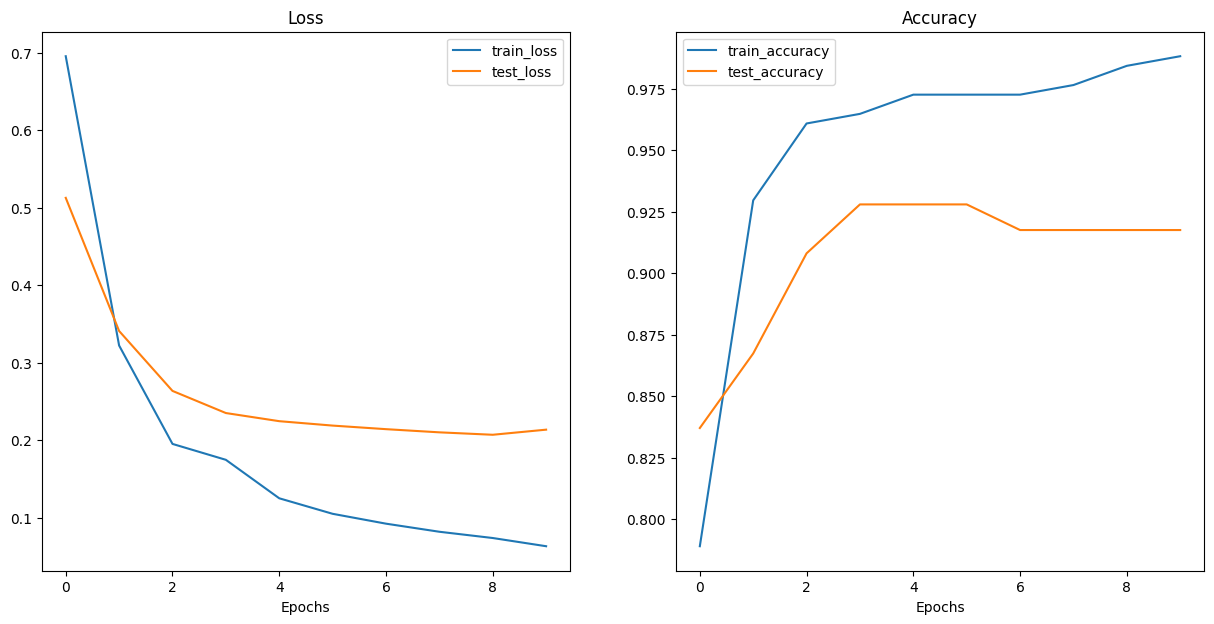

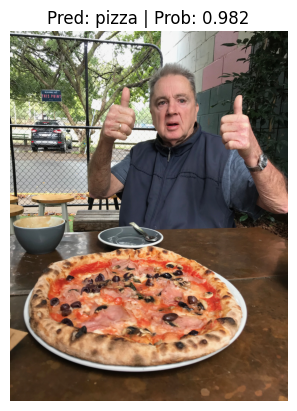

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

try:
  from torchinfo import transforms
except:
  print("Installing torchinfo...")
  !pip install -q torchinfo
  from torchinfo import summary

try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

device = "cuda" if torch.cuda.is_available() else "cpu"



# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")

train_dir = image_path / "train"
test_dir = image_path / "test"

IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

print(f"Manually create transforms: {manual_transforms}")

BATCH_SIZE = 32

# Create the data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
  train_dir = train_dir,
  test_dir = test_dir,
  transform=manual_transforms,
  batch_size = BATCH_SIZE
)

# Get pretrained weights for ViT
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# Setup an instance of the model using the pretrained weights.
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

# Change the classifier
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

pretrained_vit_transforms = pretrained_vit_weights.transforms()

# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)
